In [109]:
import json
from matplotlib import pyplot
import seaborn as sns
import pathlib
import pandas as pd
import seaborn as sns

In [110]:
sns.set_theme()

In [20]:
BENCH_RES = pathlib.Path("../bench-res.json")

if not BENCH_RES.is_file():
    raise ValueError(f"Cannot find input {BENCH_RES}")

In [21]:
def load_json():
    with BENCH_RES.open() as f:
        return json.loads(f.read())

bench_data = load_json()

In [22]:
bench_data.keys()

dict_keys(['machine_info', 'commit_info', 'benchmarks', 'datetime', 'version'])

In [23]:
bench_data["benchmarks"][0]["stats"]

{'min': 0.22130831200047396,
 'max': 0.2491278119996423,
 'mean': 0.22824300559877883,
 'stddev': 0.011828674310503719,
 'rounds': 5,
 'median': 0.22342896200279938,
 'iqr': 0.010391173998868908,
 'q1': 0.22136515674719703,
 'q3': 0.23175633074606594,
 'iqr_outliers': 1,
 'stddev_outliers': 1,
 'outliers': '1;1',
 'ld15iqr': 0.22130831200047396,
 'hd15iqr': 0.2491278119996423,
 'ops': 4.381295266317463,
 'total': 1.1412150279938942,
 'data': [0.22342896200279938,
  0.22138410499610472,
  0.22596583699487383,
  0.22130831200047396,
  0.2491278119996423],
 'iterations': 1}

In [24]:
# CHECK THAT THE STANDARD DESIVATIONS ARE VERY VERY LOW.
def get_stdevs():
    for bench in bench_data["benchmarks"]:
        yield bench["stats"]["stddev"]
list(get_stdevs())

[0.011828674310503719,
 0.016047418408410157,
 0.006855542523019015,
 0.022801606519592295,
 0.005281317420243534,
 0.0027763024259678413,
 0.00446410186335327,
 0.2722162855473112]

In [42]:
def get_names():
    for bench in bench_data["benchmarks"]:
        yield (
            bench["name"]
            .removeprefix("test_")
            .removesuffix("[100000]")
            .removesuffix("[100000]")
        )
list(get_names())

['serialize_json',
 'deserialize_json',
 'serialize_msgpack',
 'deserialize_msgpack',
 'serialize_pb',
 'deserialize_pb',
 'serialize_pyrobuf',
 'deserialize_pyrobuf']

In [45]:
def get_means():
    for bench in bench_data["benchmarks"]:
        yield bench["stats"]["mean"]
list(get_means())

[0.22824300559877883,
 0.26684772839798826,
 0.1121280746665434,
 0.18519669916592343,
 0.05472581010035356,
 0.014984651558033427,
 0.14152697866544864,
 0.2757234983340216]

In [ ]:
df = (
        pd.DataFrame({
        "name": get_names(),
        "std": get_stdevs(),
        "mean": get_means(),
    })
    .assign(
        serialize=lambda df_: ~df_["name"].str.contains("deserialize"),
        name=lambda df_: df_["name"].str.removeprefix("deserialize_").str.removeprefix("serialize_"),
    )
    .assign(
        name=lambda df_: df_["name"].mask(lambda s_: s_ == "pb", "protobuf")
    )
    .sort_values("mean")
)
df

serialize,False,True
name,,
json,0.266848,0.228243
msgpack,0.185197,0.112128
protobuf,0.014985,0.054726
pyrobuf,0.275723,0.141527


In [89]:
df.pivot(index="name", columns="serialize", values="mean").index.rename("type")

Index(['json', 'msgpack', 'protobuf', 'pyrobuf'], dtype='object', name='type')

<Axes: title={'center': 'Mean serialization/deserialization time for 100k messages'}, xlabel='name'>

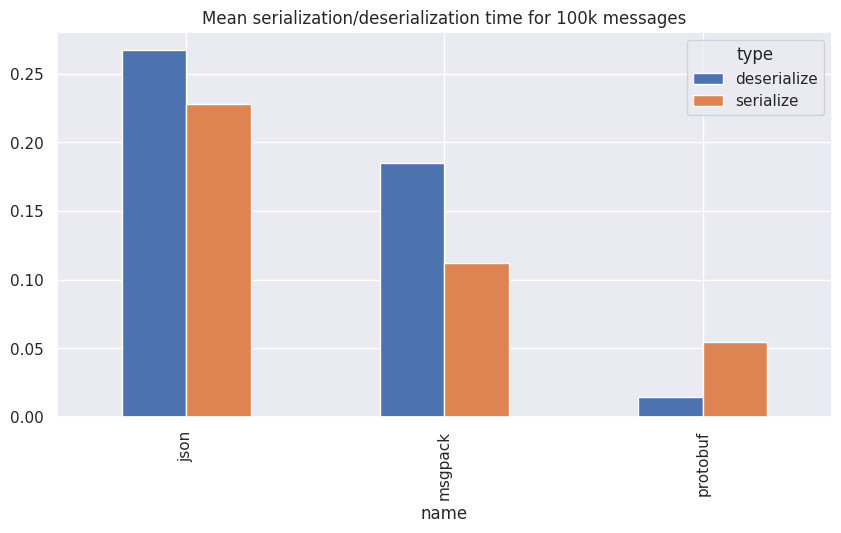

In [ ]:
def show_plot_res():
    return (
        df
        .loc[lambda df_: df_["name"] != "pyrobuf"]
        .pivot(index="name", columns="serialize", values="mean")
        .rename(columns={True: "serialize", False: "deserialize"})
        .rename_axis(columns={"serialize": "type"})
        .plot.bar(
            title="Mean serialization/deserialization time for 100k messages",
            figsize=(10, 5),
        )
    )

show_plot_res()

<Axes: title={'center': 'Mean serialization time for 100k messages'}, xlabel='name'>

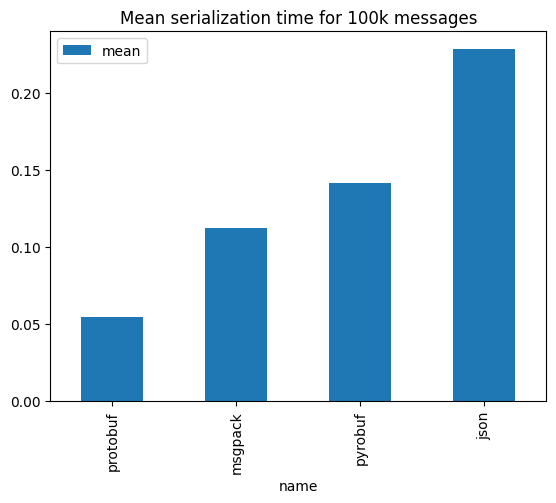

In [66]:
df.loc[df["serialize"]].plot.bar(x="name", y="mean", title="Mean serialization time for 100k messages")